In [194]:
import torch
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import einops

from quant_func import STERound
from tqdm import tqdm
import sympy as sp

#aliases
torch.steRound = STERound.apply
torch.gelu = torch.nn.functional.gelu
torch.mul_reduce = torch.prod

torch.manual_seed(10)



In [195]:
# we will use the simplest dataset... ever
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist = datasets.MNIST(root='./data', train=True, download=True,transform=transform)

train_size = int(0.9 * len(mnist))  # 54000
test_size = len(mnist) - train_size  # 6000
train_dataset, test_dataset = random_split(mnist, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [196]:
for img,labels in train_loader:
    print(img.shape,labels.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [197]:
len(train_loader) # total training batches

844

tensor([9, 6, 2, 8, 9])


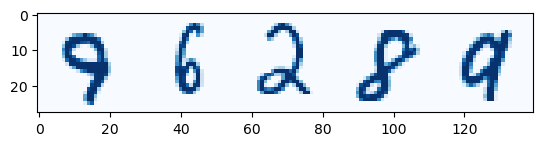

In [198]:
eg,eg_label = img[:5] , labels[:5]
eg = einops.rearrange(eg,"b c h w -> h (b w) c")
plt.imshow(eg,cmap="Blues")
print(eg_label)

In [199]:
class Qconv(torch.nn.Module):
    def  __init__ (self,in_channels,out_channels,kernel_size=3,b=2.0,e=-8.0,):
        """
        # weight tying exp_bits and depth_bits
        # note number  of output  channels  is number of filterkernels  launched
        # we will try to not just compress  but take out entire filter kernels...
        # these asserts them to be pytorch tensors
        """
        super().__init__()
       
        in_channels = torch.as_tensor(in_channels)
        out_channels = torch.as_tensor(out_channels)
        kernel_size = torch.as_tensor(kernel_size)
        b = torch.as_tensor(b)
        e= torch.as_tensor(e)

        # fan_in is just in_channels
        weight_scale = 1/ torch.sqrt(in_channels*out_channels*out_channels)
        self.weight = torch.ones(out_channels,in_channels,kernel_size,kernel_size)
        self.weight = self.weight.uniform_(-weight_scale,weight_scale)

        # 1 for each kernel (out_channel).. to perform safe broadcasting we fill the rest of them with 1
        self.exp_bit = torch.ones(out_channels,1,1,1)*e
        self.depth_bit = torch.ones(out_channels,1,1,1)*b

        # exp and depth also as trainables
        self.weight = torch.nn.Parameter(self.weight)
        self.exp_bit = torch.nn.Parameter(self.exp_bit)
        self.depth_bit = torch.nn.Parameter(self.depth_bit)
        ...
    
    def size_layer(self):
        """
        given by equation 4 : I*H*W * sum(b(i,l)
        Where O , I , H and W are the output, input, height, and
        width dimensions (so shape) of the weight tensor of layer l respec-
        tively, and b(i,l) is the bit depth of output channel i of layer l.
        """
        prods = torch.as_tensor(self.weight.shape[1:])
        size = torch.mul_reduce(prods) *  torch.sum(torch.relu(self.depth_bit))
        return size

    def _quantized_weight(self):
        b = torch.relu(self.depth_bit)
        x_upscaled = self.weight/torch.exp2(self.exp_bit)
        half = torch.exp2(b -1)
        x_clipped = torch.clip(x_upscaled,-1*half,half-1)
        x_round = torch.steRound(x_clipped)
        return torch.exp2(self.exp_bit) * x_round

    

    def __call__(self,x):
        # quantize every forward pass
        W = self._quantized_weight()
        # assert self.weight.shape==W.shape
        # valid padding or should we do same.. paper does not say
        return torch.nn.functional.conv2d(x,W,padding=1)
        
        

In [200]:
class QlinearMLP(torch.nn.Module):
    """
    Linear layer .. we will only use this to make mlp head and not attention weights
    tie each column to exp and depth bit. or else (m*n) weight would make (m*n)*3 trainable weights.
    i.e we will try to prune column weights
    """

    def __init__(self,m:int,n:int,b=2,e=-8):
        self.m , self.n = m,n
        super().__init__()
        b = torch.as_tensor(b)
        e = torch.as_tensor(e)
        # note that torch.nn.Linear(12,8).weight has a shape of 8,12
        # this is already a nn.Parameter.. no need to wrap
        self.linear = torch.nn.Linear(m,n)
        # print(self.linear)
        self.depth_bit = torch.ones(1,m) * b
        self.exp_bit = torch.ones(1,m) * e

        self.depth_bit = torch.nn.Parameter(self.depth_bit)
        self.exp_bit = torch.nn.Parameter(self.exp_bit)

    def size_layer(self):
        # we will just return number of columns
        return torch.tensor(self.m)

    def _quantized_weight(self):
        b = torch.relu(self.depth_bit)
        # print(self.linear.weight.shape , self.exp_bit.shape) # should be (m,n) * (1,n)
        x_upscaled = self.linear.weight/torch.exp2(self.exp_bit)
        half = torch.exp2(b -1)
        x_clipped = torch.clip(x_upscaled,-1*half,half-1)
        x_round = torch.steRound(x_clipped)
        return torch.exp2(self.exp_bit) * x_round

    def __call__(self,x):
        # quantize weight every forward pass
        W = self._quantized_weight()
        return torch.nn.functional.linear(x,W,bias=self.linear.bias)
        
        

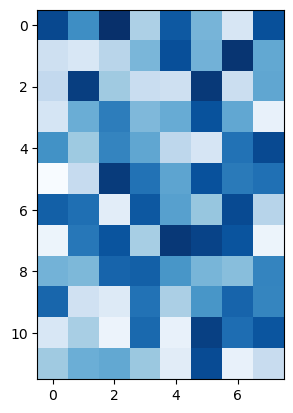

In [201]:
with torch.no_grad():
    W1 = QlinearMLP(8,12)
    x = torch.randn((32,8))
    out = W1(x)
    assert out.shape == torch.Size((32,12))
    plt.imshow(W1.linear.weight.float(),cmap="Blues")

In [202]:
@torch.no_grad
def inspect_weights(out,layer):
    assert isinstance(layer,Qconv), "Hein? should be Qconv layer"
    out = out.to("cpu")
    kernel = layer._quantized_weight().to("cpu")
    _,in_channels,k,_ = kernel.shape
    if in_channels>1:
        kernel = kernel[:,0,:,:][:,None,:,:]
    
    kernel_plot = einops.rearrange(kernel,"out_ch in_ch k1 k2 ->  (in_ch k1) (out_ch k2)")
    out_plot = einops.rearrange(out,"b c h w -> (b h) (c w)")


    plt.figure(figsize=(15,8))
    plt.imshow(kernel_plot.float(),cmap="gray")
    plt.show()
    plt.figure(figsize=(15,8))
    plt.imshow(out_plot.float(),cmap="Blues")
    plt.show()
    return out_plot,kernel_plot
    

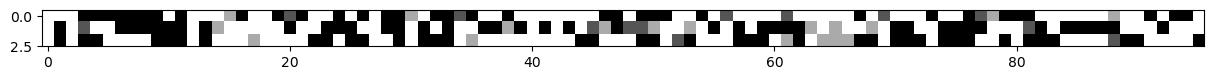

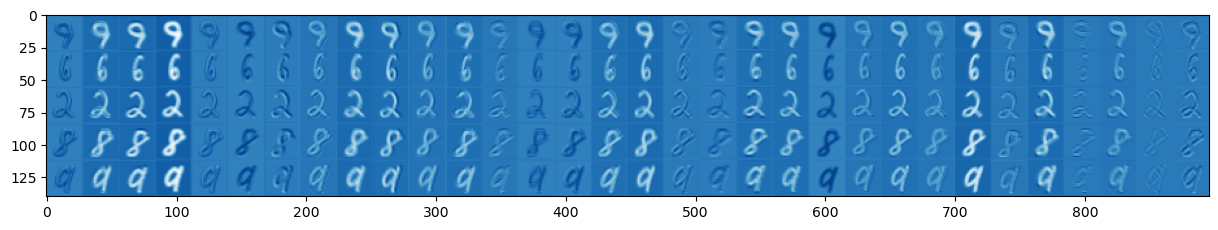

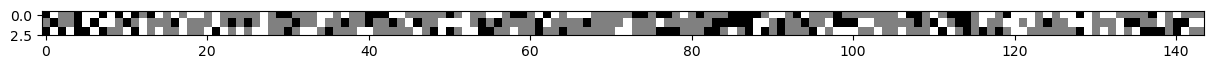

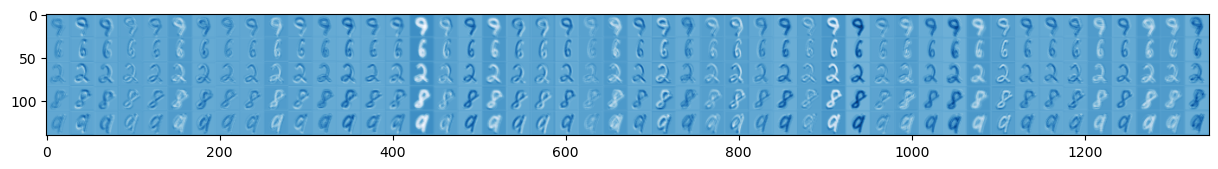

(tensor([[-2.8481e-04,  2.6375e-11, -3.2365e-05,  ..., -3.7543e-04,
          -2.6539e-04, -2.7187e-04],
         [-2.7187e-04, -1.2299e-04, -1.9419e-04,  ..., -5.4373e-04,
          -4.4016e-04, -4.5958e-04],
         [-3.6896e-04, -1.8124e-04, -2.3950e-04,  ..., -6.6672e-04,
          -5.3726e-04, -5.3078e-04],
         ...,
         [-3.6896e-04, -1.8124e-04, -2.3950e-04,  ..., -6.6672e-04,
          -5.3726e-04, -5.3078e-04],
         [-3.3659e-04, -1.8772e-04, -2.5892e-04,  ..., -4.2722e-04,
          -3.7543e-04, -4.4664e-04],
         [-2.3950e-04, -3.3659e-04, -4.4016e-04,  ..., -1.2299e-04,
          -9.0622e-05, -1.8124e-04]]),
 tensor([[-0.0039,  0.0039, -0.0000, -0.0000, -0.0039,  0.0039,  0.0039, -0.0039,
           0.0039, -0.0039,  0.0039, -0.0039, -0.0000, -0.0039,  0.0039,  0.0000,
           0.0039,  0.0000,  0.0039,  0.0039,  0.0000,  0.0039, -0.0000, -0.0000,
          -0.0000,  0.0000, -0.0000,  0.0039, -0.0000, -0.0039, -0.0039, -0.0000,
          -0.0000, -0.0000

In [203]:
input_img = torch.as_tensor(img[:5]) # 1,28,28
qconv_layer1 = Qconv(1,32)
qconv_layer2 = Qconv(32,48)

out1 = qconv_layer1(input_img)
out2 = qconv_layer2(out1)

inspect_weights(out1,qconv_layer1)
inspect_weights(out2,qconv_layer2)


In [204]:
class QconvModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Qconv(1, 16,b=2)
        self.conv2 = Qconv(16,16,b=2)
        self.conv3 = Qconv(16,32,b=1.5,e=-7)
        self.conv4 = Qconv(32,32,b=1.3,e=-6)
        
        self.pool = torch.nn.MaxPool2d(2, 2)

        self.bn1 = torch.nn.BatchNorm2d(16)
        self.bn2 = torch.nn.BatchNorm2d(32)

        self.L1 = QlinearMLP(32*7*7, 32)
        self.L2 = QlinearMLP(32, 10)


    def forward(self, x):
        # (2 convolutions -> bn -> pool) * 2 
        conv1_out = torch.gelu(self.conv1(x))
        conv2_out = torch.gelu(self.conv2(conv1_out))
        conv2_out = self.bn1(conv2_out)
        pool1 = self.pool(conv2_out)

        conv3_out = torch.gelu(self.conv3(pool1))
        conv4_out = torch.gelu(self.conv4(conv3_out))
        conv4_out = self.bn2(conv4_out)
        pool2 = self.pool(conv4_out)

        # then linear layers
        flat = torch.flatten(pool2, 1) # flatten except batch
        l1 = torch.gelu(self.L1(flat))
        l2 = torch.gelu(self.L2(l1))
        logits = l2
        return logits

In [205]:
class QTrainer:
    """
    we will use bfloat16 training on h100...
    for my pc we will just do fp32 training
    """

    def __init__(self,dtype=torch.float32,logging=False,tag="low_bval",project_name="convolution_compressing"):
        self.model = QconvModel()
        assert isinstance(dtype,torch.dtype),"Hein? unrecognized dtype"
        self.dtype = dtype
        self.logging = logging

        if self.logging:
            print("logging costs around 0.5 secs more per iteration.")
            self.tag = tag
            self.project_name = project_name
            self._setup_logging()
        

        # does not work on my machine with less precision...
        # if self.dtype == torch.float32:
        #     # dont need for high precision right ?
        #     torch.set_float32_matmul_precision("medium")

        print(f"Training with {self.dtype=} precision")


        # self.scaler = torch.amp.GradScaler()
        
        self.model = self.model.to(self.dtype)
        self.model = torch.compile(self.model)
        self.model.to("cuda")
        self.track_decay = []
        self.track_activekernels = []
        self.track_loss = []

    
        self.optim = torch.optim.AdamW(
            self.model.parameters(),
            weight_decay=1e-3)
    
        self.gamma = (1/10) # high for drama!! but should be around 0.05 or something.. compression factor
        # we need to calculate total number of parameters at initialization (papaer calls it N)
        # here since everything is trainable

        self.tot_init = sum(p.numel() for group in self.optim.param_groups for p in group['params'] if p.requires_grad)
        self.tot_qparams = torch.sum(torch.tensor([p_weight.numel() for p,p_weight in self.model.named_parameters() if "_bit" in p]))
    
        print(f"Total Parameters {self.tot_init=}")
        print(f"of which compression are :{self.tot_qparams=}")
        print(f"compression factor at init {self.gamma * self._qlayersize()}")
    
        # print(self._qlayersize())
        print(self._activekernelscount())

    def _setup_logging(self):
        import os
        os.getenv("comet_api")
        
        from comet_ml import start
        from comet_ml.integration.pytorch import log_model,watch
        
        self.experiment = start(
          api_key=os.getenv("comet_api"),
          project_name=self.project_name,
          workspace="adishourya"
        )
        self.experiment.add_tag(self.tag)
        
        # watch weights [to be precise i want to watch sparsity.. but we will see that later]
        # this is costly
        watch(self.model)


    def _qlayersize(self):
        size_conv = torch.sum(torch.tensor([layer.size_layer() for layer in self.model.modules() if isinstance(layer,Qconv)]))
        size_lin =  torch.sum(torch.tensor([layer.size_layer() for layer in self.model.modules() if isinstance(layer,QlinearMLP)]))
        # [print("->",layer,layer.size_layer()) for layer in self.model.modules() if isinstance(layer,QlinearMLP)]
        # print(size_lin,size_conv)
        return (size_conv + size_lin)/self.tot_init


    def _activekernelscount(self):
        kernel_counts = dict()
        for name,layer in self.model.named_modules():
            if isinstance(layer,Qconv):
                depths = torch.relu(layer.depth_bit)
                count =torch.sum(torch.where(depths>0,1,0)).item()
                kernel_counts[name] = count
        return kernel_counts


    def _track(self,loss,activekernels,bit_decay,i):
        self.track_loss.append(loss)
        self.track_activekernels.append(activekernels.values())
        self.track_decay.append(bit_decay)
        if self.logging:
             experiment.log_metric(name="loss", value=loss, step=i)
             experiment.log_metric(name="decay", value=bit_decay, step=i)
             experiment.log_metric(name="activekernels", value=sum(activekernels.values()), step=i)
        

    
    # @torch.compile # this will not work if you want to track modules states in dict and such.. dynamo error. compile model instead.
    def train(self,num_epochs=10):
        pbar_epoch = tqdm(range(num_epochs))
        for epoch in pbar_epoch:
            i = 0
            for batch_img, batch_label in train_loader:
                
                batch_img = batch_img.to("cuda").to(self.dtype)
                batch_label = batch_label.to("cuda")

                # bfloat16 with cross entropy needs autocasting 
                with torch.autocast(device_type="cuda",dtype=self.dtype):
                    out = self.model(batch_img)
                    bit_decay = self._qlayersize()
                    loss = torch.nn.functional.cross_entropy(input=out,target=batch_label) + self.gamma * bit_decay

                self.optim.zero_grad() # commented (bugged) out to show quick grad accum which drops conv filters
                loss.backward()
                self.optim.step()
                i = i +1
                if i %50 == 0:
                    activekernels = self._activekernelscount()
                    pbar_epoch.set_postfix(
                        loss=loss.item(),
                        activekernels = activekernels.values(),
                        decay=self.gamma*bit_decay.item(),
                    )
                    self._track(loss.item(),activekernels,self.gamma*bit_decay.item(),i)
                        
        if self.logging:
            log_model(experiment,model=self.model,model_name=self.tag)
        return self.model
    


In [206]:
qmodel = QTrainer(logging=False,tag="low_bval",project_name="convolution_compressing")

Training with self.dtype=torch.float32 precision
Total Parameters self.tot_init=70298
of which compression are :self.tot_qparams=tensor(3392)
compression factor at init 0.036115966737270355
{'_orig_mod.conv1': 16, '_orig_mod.conv2': 16, '_orig_mod.conv3': 32, '_orig_mod.conv4': 32}


In [207]:
qmodel.train(50)

100%|██████| 50/50 [03:53<00:00,  4.68s/it, activekernels=dict_values([16, 16, 32, 19]), decay=0.0365, loss=0.0595]


OptimizedModule(
  (_orig_mod): QconvModel(
    (conv1): Qconv()
    (conv2): Qconv()
    (conv3): Qconv()
    (conv4): Qconv()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (L1): QlinearMLP(
      (linear): Linear(in_features=1568, out_features=32, bias=True)
    )
    (L2): QlinearMLP(
      (linear): Linear(in_features=32, out_features=10, bias=True)
    )
  )
)

In [208]:
with torch.no_grad():
    out_model = qmodel.model
    logits =out_model(img.to("cuda"))
    response = torch.argmax(logits,dim=-1)
    # print(logits)
    print("score:",torch.sum(response==labels.to("cuda")))
    print("of:",labels.shape)
    print("=======Accuracy========")

W0421 15:34:31.312000 75374 site-packages/torch/_dynamo/convert_frame.py:844] [28/8] torch._dynamo hit config.cache_size_limit (8)
W0421 15:34:31.312000 75374 site-packages/torch/_dynamo/convert_frame.py:844] [28/8]    function: '__call__' (/tmp/ipykernel_75374/2421545153.py:53)
W0421 15:34:31.312000 75374 site-packages/torch/_dynamo/convert_frame.py:844] [28/8]    last reason: 28/0: GLOBAL_STATE changed: grad_mode 
W0421 15:34:31.312000 75374 site-packages/torch/_dynamo/convert_frame.py:844] [28/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0421 15:34:31.312000 75374 site-packages/torch/_dynamo/convert_frame.py:844] [28/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


score: tensor(64, device='cuda:0')
of: torch.Size([64])
=======Accuracy========


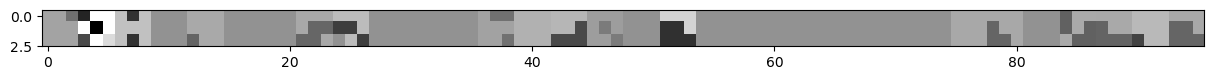

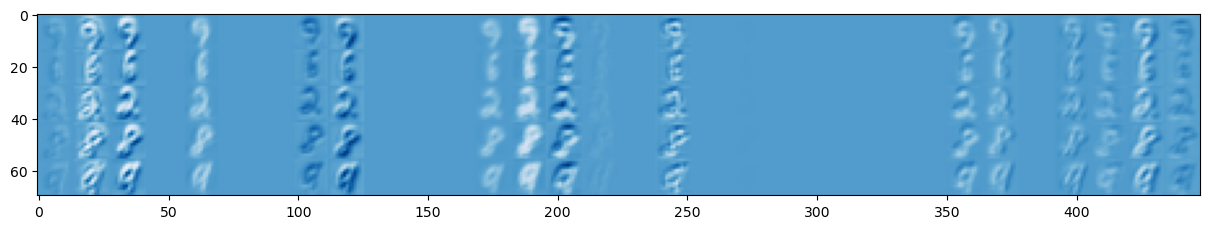

torch.Size([3, 96])


AttributeError: 'QTrainer' object has no attribute 'experiment'

In [209]:
# log more things you find interesting
with torch.no_grad():
    out_model = qmodel.model
    out1 = out_model.conv1(input_img.to("cuda"))
    out2 = out_model.conv2(out1)
    out2 = out_model.bn1(out2)
    
    pool1 = out_model.pool(out2)
    out3 = out_model.conv3(pool1)
    out4 = out_model.conv4(out3)
    
    out,w = inspect_weights(out4,out_model.conv4)
    print(w.shape)
    qmodel.experiment.log_image(out,name="layer_4")
    display(sp.Matrix(w))

In [ ]:
# qmodel.experiment.end()